# Proyek Akhir: Menyelesaikan Permasalahan Perusahaan Edutech

- Nama: Albar Pambagio Arioseto 
- Email: albarpambagio@gmail.com    
- Id Dicoding: albarpambagio

## Persiapan

### Menyiapkan library yang dibutuhkan

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
import joblib
import os
import json

### Menyiapkan data yang akan digunakan

In [10]:
try:
    # Fetch the dataset
    student_data = fetch_ucirepo(id=697)
    
    # Create DataFrame with validation
    if hasattr(student_data.data, 'original'):
        df = student_data.data.original.copy()
    else:
        df = pd.concat([student_data.data.features, student_data.data.targets], axis=1)
    
    # Validate we have the target column
    if 'Target' not in df.columns:
        raise ValueError("Target column not found in dataset")
        
    print('Data shape:', df.shape)
    print('First 5 rows:')
    display(df.head())
    
except Exception as e:
    print(f"Error loading data: {str(e)}")
    # Create empty DataFrame with expected structure if fetch fails
    df = pd.DataFrame(columns=['Target'])

Data shape: (4424, 37)
First 5 rows:


,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


## Data Understanding

### Target Variable Analysis

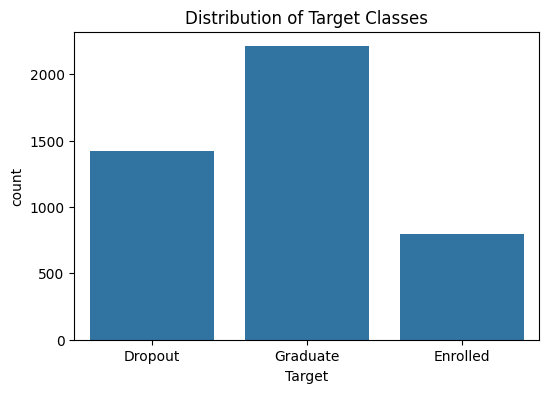

Target
Graduate    0.499322
Dropout     0.321203
Enrolled    0.179476
Name: proportion, dtype: float64

In [11]:
if not df.empty:
    plt.figure(figsize=(6,4))
    sns.countplot(x='Target', data=df)
    plt.title('Distribution of Target Classes')
    plt.show()
    display(df['Target'].value_counts(normalize=True))
    df['Target'].value_counts(normalize=True).to_csv('eda_outputs/eda_target_value_counts.csv')
else:
    print("No data available for visualization")

### Demographic Features

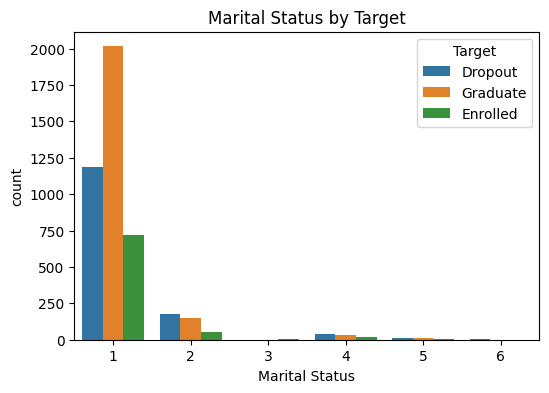

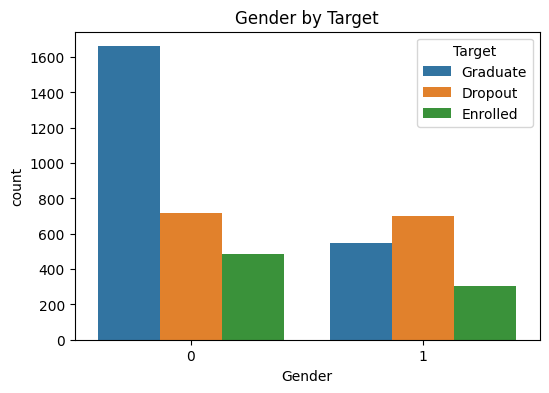

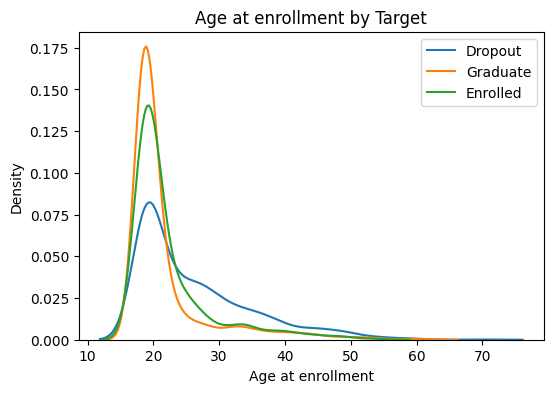

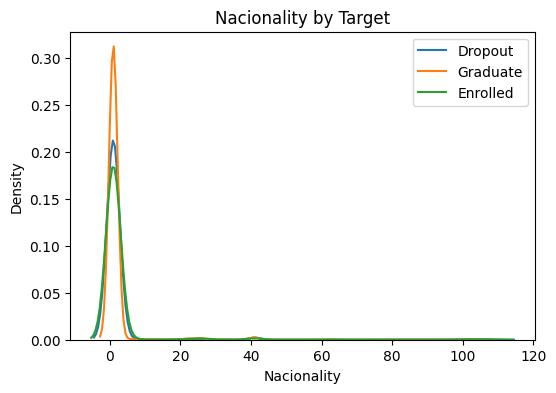

In [12]:
if not df.empty:
    demographic_vars = ['Marital Status', 'Gender', 'Age at enrollment', 'Nacionality']
    available_demographic_vars = [var for var in demographic_vars if var in df.columns]
    
    if len(available_demographic_vars) < len(demographic_vars):
        missing = set(demographic_vars) - set(available_demographic_vars)
        print(f"Warning: Missing demographic columns: {missing}")
    
    for var in available_demographic_vars:
        plt.figure(figsize=(6,4))
        if df[var].nunique() < 20:
            sns.countplot(x=var, hue='Target', data=df)
            vc = df.groupby('Target')[var].value_counts().unstack(fill_value=0)
            clean_var_name = (
                var.replace(" ", "_")
                   .replace("(", "")
                   .replace(")", "")
                   .replace("'", "")
                   .replace("/", "_")
                   .replace("\\", "_")
                   .lower()
            )
            vc.to_csv(f'eda_outputs/eda_{clean_var_name}_by_target.csv')
        else:
            for t in df['Target'].unique():
                sns.kdeplot(df[df['Target']==t][var], label=t)
            plt.legend()
        plt.title(f'{var} by Target')
        plt.show()
else:
    print("No data available for visualization")

### Data Preparation / Preprocessing

In [13]:
def standardize_feature_names(df):
    """Ensure consistent feature naming across entire pipeline"""
    if df.empty:
        return df
        
    df = df.copy()
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('/', '_')
                 .replace('(', '').replace(')', '').replace("'", "").strip()
                 for col in df.columns]
    return df

# Apply to original data with validation
df_clean = standardize_feature_names(df) if not df.empty else pd.DataFrame()

# Verify all expected features are present
required_features = [
    'Marital_Status', 'Application_mode', 'Application_order', 'Course',
    'Daytime_evening_attendance', 'Previous_qualification',
    'Previous_qualification_grade', 'Nacionality',
    'Mothers_qualification', 'Fathers_qualification',
    'Mothers_occupation', 'Fathers_occupation', 'Admission_grade',
    'Displaced', 'Educational_special_needs', 'Debtor',
    'Tuition_fees_up_to_date', 'Gender', 'Scholarship_holder',
    'Age_at_enrollment', 'International',
    'Curricular_units_1st_sem_credited',
    'Curricular_units_1st_sem_enrolled',
    'Curricular_units_1st_sem_evaluations',
    'Curricular_units_1st_sem_approved',
    'Curricular_units_1st_sem_grade',
    'Curricular_units_1st_sem_without_evaluations',
    'Curricular_units_2nd_sem_credited',
    'Curricular_units_2nd_sem_enrolled',
    'Curricular_units_2nd_sem_evaluations',
    'Curricular_units_2nd_sem_approved',
    'Curricular_units_2nd_sem_grade',
    'Curricular_units_2nd_sem_without_evaluations',
    'Unemployment_rate', 'Inflation_rate', 'GDP'
]

if not df_clean.empty:
    missing_features = [f for f in required_features if f not in df_clean.columns]
    if missing_features:
        print(f"Warning: {len(missing_features)} features missing. Adding with default values.")
        for f in missing_features:
            df_clean[f] = 0  # Or appropriate default value
else:
    print("No data available for preprocessing")

## Modeling

In [14]:
if not df_clean.empty and 'Target' in df_clean.columns:
    # Prepare data
    X = df_clean.drop('Target', axis=1)
    y = df_clean['Target']

    # Check for missing values
    if X.isnull().sum().sum() > 0 or y.isnull().sum() > 0:
        print("Warning: Missing values found. Handling them...")
        X = X.fillna(0)  # Simple imputation for demo purposes
        y = y.fillna(y.mode()[0])  # Fill with most common class

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Train GradientBoostingClassifier
    model = GradientBoostingClassifier(random_state=42)
    model.fit(X_train, y_train)
    
    print("Model training completed successfully")
else:
    print("No valid data available for modeling")
    model = None

Model training completed successfully


## Evaluation

In [15]:
def safe_evaluation(model, X_test, y_test):
    """Evaluate model using confusion matrix, class report, and feature importance plots."""
    if model is None or X_test.empty or y_test.empty:
        print("Cannot evaluate - no model or test data available")
        return
    
    try:
        y_pred = model.predict(X_test)
        # Remove unused y_proba unless needed:
        if 'precision' in classification_report(y_test, y_pred):
            y_proba = model.predict_proba(X_test)  # Only calculate if used
        
        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.savefig('model_outputs/confusion_matrix.png', dpi=300)
        plt.close()
        
        # Save confusion matrix as CSV
        pd.DataFrame(cm).to_csv('model_outputs/confusion_matrix.csv', index=False)
        
        # Classification report
        cr = classification_report(y_test, y_pred, output_dict=True)
        cr_df = pd.DataFrame(cr).transpose()
        class_rows = [c for c in cr_df.index if c not in ['accuracy', 'macro avg', 'weighted avg']]
        
        # Export and plot
        cr_df.loc[class_rows, ['precision', 'recall', 'f1-score']].to_csv('model_outputs/classification_report_plot.csv')
        
        plt.figure(figsize=(8, 4))
        sns.heatmap(cr_df.loc[class_rows, ['precision', 'recall', 'f1-score']], 
                   annot=True, cmap='viridis')
        plt.title('Classification Report')
        plt.tight_layout()
        plt.savefig('model_outputs/classification_report.png', dpi=300)
        plt.close()
        
        # Feature importance
        try:
            result = permutation_importance(
                model,
                X_test,
                y_test,
                n_repeats=10,
                random_state=42,
                n_jobs=-1
            )
            
            importance_df = pd.DataFrame({
                'feature': X_test.columns,
                'importance': result.importances_mean
            }).sort_values('importance', ascending=False)
            
            importance_df.to_csv('model_outputs/feature_importance.csv', index=False)
            
            plt.figure(figsize=(12, 8))
            sns.barplot(x='importance', y='feature', 
                       data=importance_df.head(20), palette='viridis')
            plt.title('Top 20 Most Important Features (Permutation Importance)')
            plt.tight_layout()
            plt.savefig('model_outputs/feature_importance_plot.png', dpi=300)
            plt.close()
            
        except Exception as e:
            print(f"Permutation importance failed: {str(e)}")
            if hasattr(model, 'feature_importances_'):
                importance_df = pd.DataFrame({
                    'feature': X_test.columns,
                    'importance': model.feature_importances_
                }).sort_values('importance', ascending=False)
                
                importance_df.to_csv('model_outputs/feature_importance_fallback.csv', index=False)
                
                plt.figure(figsize=(12, 8))
                sns.barplot(x='importance', y='feature', 
                           data=importance_df.head(20), palette='viridis')
                plt.title('Top 20 Most Important Features (Native Importance)')
                plt.tight_layout()
                plt.savefig('model_outputs/feature_importance_fallback_plot.png', dpi=300)
                plt.close()
        
        print("All evaluations completed successfully")
        
    except Exception as e:
        print(f"Evaluation failed: {str(e)}")

# Run evaluation
if model is not None and 'X_test' in locals() and 'y_test' in locals():
    safe_evaluation(model, X_test, y_test)
else:
    print("Cannot evaluate - model or test data not available")

C:\Users\USER\AppData\Local\Temp\ipykernel_8864\3891739618.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature',


All evaluations completed successfully


### Model Saving and Prediction

In [16]:
if model is not None:
    # Save the model
    joblib.dump(model, 'model_outputs/final_student_dropout_model.joblib')
    
    # Save required features for production
    with open('model_outputs/model_features.json', 'w') as f:
        json.dump(required_features, f)
    
    # Prediction function
    def predict_with_clean_features(model, data, required_features):
        """Ensure consistent feature names and all required features present, then predict."""
        if model is None or data.empty:
            print("No model or data provided")
            return None
            
        data_clean = standardize_feature_names(data)
        
        # Add missing features with default values
        for col in required_features:
            if col not in data_clean.columns and col != 'Target':
                data_clean[col] = 0
        
        X_pred = data_clean[required_features]
        
        preds = model.predict(X_pred)
        proba = model.predict_proba(X_pred)
        
        result = data_clean.copy()
        result['prediction_label'] = preds
        result['prediction_score'] = proba.max(axis=1)
        
        return result
    
    # Example prediction
    if not df_clean.empty:
        predictions = predict_with_clean_features(model, df, required_features)
        if predictions is not None:
            display(predictions[['Target', 'prediction_label', 'prediction_score']].head())
    else:
        print("No data available for prediction example")
else:
    print("No model available to save")

,Target,prediction_label,prediction_score
0,Dropout,Dropout,0.572270
1,Graduate,Graduate,0.621591
2,Dropout,Dropout,0.978466
3,Graduate,Graduate,0.681140
4,Graduate,Graduate,0.870731
